# Latent Space

> Scripts to visualize and explore the Latent Space

In [16]:
#| default_exp latent_space

In [17]:
#| export
#| hide
import numpy as np
from itertools import combinations
from scipy.spatial import distance
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import LabelEncoder
from typing import Optional, List, Any, Union, Dict
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import umap.umap_ as umap
from sklearn.preprocessing import LabelEncoder

In [18]:
#| hide
from fastcore.test import test_eq, test_close

## Latent Space

### Plot 2 dimensions

In [19]:
#| export
def plot_2d_latent_space(
    latent_representations: np.ndarray,
    labels: np.ndarray,
    features: Optional[np.ndarray] = None,
    feature_names: Optional[List[str]] = None,
    figsize: tuple = (12, 12),
    save_path: Optional[str] = None,
    many_classes: bool = False,
    show_legend: bool = True,
    legend_fontsize: int = 8,
    **kwargs: Any
) -> None:
    # Normalize data if necessary
    latent_representations = (latent_representations - np.mean(latent_representations, axis=0)) / np.std(latent_representations, axis=0)

    # Encode string labels to integers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    class_names = label_encoder.classes_

    # Use a colormap for better color differentiation
    cmap = plt.get_cmap('tab20', len(class_names))
    markers = ['o', 's', '^', 'v', 'D', '<', '>', 'p', '*', 'h', 'H', '8']

    # Create figure and gridspec layout
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[5, 1], wspace=0.3, hspace=0.3)

    ax_main = fig.add_subplot(gs[0, 0])
    
    # Plot the latent representations with class colors
    if many_classes:
        for class_idx, class_name in enumerate(class_names):
            class_mask = (encoded_labels == class_idx)
            color = cmap(class_idx % cmap.N)
            marker = markers[class_idx % len(markers)]
            ax_main.scatter(latent_representations[class_mask, 0],
                            latent_representations[class_mask, 1],
                            label=class_name, marker=marker, color=color, s=30, **kwargs)
        if show_legend:
            ax_main.legend(title="Classes", fontsize=legend_fontsize, loc='best')
    else:
        unique_labels = np.unique(encoded_labels)
        for class_idx in unique_labels:
            class_name = class_names[class_idx]
            class_mask = (encoded_labels == class_idx)
            color = cmap(class_idx % cmap.N)
            ax_main.scatter(latent_representations[class_mask, 0],
                            latent_representations[class_mask, 1],
                            label=class_name, color=color, s=30, **kwargs)
        if show_legend:
            ax_main.legend(title="Classes", fontsize=legend_fontsize)

    ax_main.set_title('2D Latent Space Visualization')
    ax_main.set_xlabel('Dimension 1')
    ax_main.set_ylabel('Dimension 2')
    
    # Set equal aspect ratio and adjust limits to make the plot square
    ax_main.set_aspect('equal')
    
    x_min, x_max = latent_representations[:, 0].min(), latent_representations[:, 0].max()
    y_min, y_max = latent_representations[:, 1].min(), latent_representations[:, 1].max()
    
    max_range = max(x_max - x_min, y_max - y_min)
    
    ax_main.set_xlim(x_min - (max_range - (x_max - x_min)) / 2,
                     x_max + (max_range - (x_max - x_min)) / 2)
    
    ax_main.set_ylim(y_min - (max_range - (y_max - y_min)) / 2,
                     y_max + (max_range - (y_max - y_min)) / 2)

    # Plot feature distributions if feature data is provided
    if features is not None and feature_names is not None:
        ax_hist_x = fig.add_subplot(gs[1, 0], sharex=ax_main)
        ax_hist_y = fig.add_subplot(gs[0, 1], sharey=ax_main)

        x_bins = np.linspace(x_min, x_max, 100)

        for feature_index, feature_name in enumerate(feature_names):
            avg_feature_norm_x = [
                features[(latent_representations[:, 0] >= x_bins[i]) & (latent_representations[:, 0] < x_bins[i+1]), feature_index].mean()
                if np.any((latent_representations[:, 0] >= x_bins[i]) & (latent_representations[:, 0] < x_bins[i+1]))
                else 0 for i in range(len(x_bins)-1)
            ]
            avg_feature_norm_x_normed = (avg_feature_norm_x - np.min(avg_feature_norm_x)) / (np.ptp(avg_feature_norm_x) + 1e-8)
            ax_hist_x.plot((x_bins[:-1] + x_bins[1:]) / 2, avg_feature_norm_x_normed, label=f'{feature_name}')

        y_bins = np.linspace(y_min, y_max, 100)

        for feature_index, feature_name in enumerate(feature_names):
            avg_feature_norm_y = [
                features[(latent_representations[:, 1] >= y_bins[i]) & (latent_representations[:, 1] < y_bins[i+1]), feature_index].mean()
                if np.any((latent_representations[:, 1] >= y_bins[i]) & (latent_representations[:, 1] < y_bins[i+1]))
                else 0 for i in range(len(y_bins)-1)
            ]
            avg_feature_norm_y_normed = (avg_feature_norm_y - np.min(avg_feature_norm_y)) / (np.ptp(avg_feature_norm_y) + 1e-8)
            ax_hist_y.plot(avg_feature_norm_y_normed, (y_bins[:-1] + y_bins[1:]) / 2, label=f'{feature_name}')

        ax_hist_x.set_title('Normalized Horizontal Feature Distributions')
        ax_hist_x.set_xlabel('Dimension 1')
        ax_hist_y.set_title('Normalized Vertical Feature Distributions')
        ax_hist_y.set_ylabel('Dimension 2')

        # Hide tick labels on shared axes to avoid clutter
        plt.setp(ax_hist_x.get_xticklabels(), visible=False)
        plt.setp(ax_hist_y.get_yticklabels(), visible=False)

    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved plot to {save_path}")

    plt.show()

In [20]:
#| export
def plot_combined_2d_latent_space(
    real_latent: np.ndarray,                      # Latent representations of real data.
    synthetic_latent: np.ndarray,                 # Latent representations of synthetic data.
    synthetic_labels: Optional[Union[int, List[int]]] = 1,  # Labels for synthetic data. Can be a single label or a list of labels.
    figsize: tuple = (12, 9),                     # Size of the figure.
    save_path: Optional[str] = None,              # Optional path to save the plot image.
    show_legend: bool = True,                     # Flag to show or hide the legend.
    annotation_mode: str = 'legend'               # Mode for annotation: 'legend' for colored dots, 'numbers' for numeric annotations.
) -> None:
    """
    Plots the combined latent space of real and synthetic data.
    Assumes the latent space is already 2D.
    """
    # Concatenate real and synthetic latent representations
    combined_latent = np.concatenate([real_latent, synthetic_latent], axis=0)

    # Create labels for real and synthetic data
    real_labels = np.zeros(real_latent.shape[0], dtype=int)
    if isinstance(synthetic_labels, int):
        synthetic_labels = np.full(synthetic_latent.shape[0], synthetic_labels, dtype=int)
    synthetic_labels = np.array(synthetic_labels)
    combined_labels = np.concatenate([real_labels, synthetic_labels], axis=0)

    # Ensure the latent space is 2D
    assert combined_latent.shape[1] == 2, "The latent space representations must be 2D."

    # Create a color map with enough colors
    cmap = plt.get_cmap('tab20', len(np.unique(combined_labels)))
    norm = mcolors.BoundaryNorm(boundaries=np.arange(len(np.unique(combined_labels))+1)-0.5, ncolors=len(np.unique(combined_labels)))

    # Plotting
    plt.figure(figsize=figsize)
    scatter = plt.scatter(combined_latent[:, 0], combined_latent[:, 1], c=combined_labels, cmap=cmap, norm=norm, alpha=0.7)
    
    if annotation_mode == 'legend' and show_legend:
        # Create custom legend
        unique_labels = np.unique(combined_labels)
        custom_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(label)), markersize=10) for label in unique_labels]
        custom_labels = ["Real"] + [f"Synthetic {label}" for label in np.unique(synthetic_labels)]
        plt.legend(custom_handles, custom_labels, title="Classes", loc='upper right')  # Place legend in the upper right corner
    
    elif annotation_mode == 'numbers':
        # Annotate only synthetic points with their class labels
        for i in range(real_latent.shape[0], combined_latent.shape[0]):
            plt.annotate(combined_labels[i], (combined_latent[i, 0], combined_latent[i, 1]), fontsize=9, alpha=0.7)

    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path)
        print(f"Saved plot to {save_path}")
    else:
        plt.show()

## Reduce dimensions

In [21]:
#| export
def reduce_dimensions_latent_space(latent_representations: np.ndarray,  # Precomputed latent representations (numpy array).
                      labels: np.ndarray,                  # Labels for the data points, used for coloring in the plot.
                      techniques: List[str] = ['PCA'],     # Techniques to use for reduction ('PCA', 't-SNE', 'UMAP', 'LDA').
                      n_components: int = 2,               # Number of dimensions to reduce to (1, 2, or 3).
                      figsize: tuple = (12, 9),            # Size of the figure for each subplot.
                      save_path: Optional[str] = None,     # Optional path to save the plot image.
                      many_classes: bool = False,          # Flag to use enhanced plotting for many classes.
                      grid_view: bool = True,              # Flag to plot all techniques in a single grid view.
                      class_names: Optional[List[str]] = None,  # Optional class names for the legend
                      show_legend: bool = True,            # Flag to show or hide the legend
                      plot: bool = True,                   # Flag to plot the latent space
                      **kwargs: Any                        # Additional keyword arguments for dimensionality reduction methods.
                     ) -> Dict[str, np.ndarray]:
    """
    Reduces dimensions of latent representations using specified techniques and optionally plots the results.
    
    Returns:
        A dictionary containing the reduced latent space for each technique.
    """
    # Encode string labels to integers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    
    # Use provided class names if available
    if class_names:
        class_names = class_names
    else:
        class_names = label_encoder.classes_

    models = {
        'PCA': PCA(n_components=n_components),
        't-SNE': TSNE(n_components=n_components, **kwargs),
        'UMAP': umap.UMAP(n_components=n_components, **kwargs),
        'LDA': LinearDiscriminantAnalysis(n_components=n_components)
    }

    reduced_latent_spaces = {}

    if plot:
        markers = ['o', 's', '^', 'v', 'D', '<', '>', 'p', '*', 'h', 'H', '8']  # Marker styles
        n_techniques = len(techniques)
        if grid_view:
            fig, axs = plt.subplots(1, n_techniques, figsize=(figsize[0] * n_techniques, figsize[1]))
            if n_techniques == 1:
                axs = [axs]
        else:
            axs = [None] * n_techniques

    for idx, technique in enumerate(techniques):
        model = models.get(technique)
        if not model:
            continue  # Skip if model not found in dictionary

        if technique == 'LDA':
            results = model.fit_transform(latent_representations, encoded_labels)
        else:
            results = model.fit_transform(latent_representations)

        reduced_latent_spaces[technique] = results

        if plot:
            if n_components == 3:
                if grid_view:
                    ax = fig.add_subplot(1, n_techniques, idx+1, projection='3d')
                else:
                    fig = plt.figure(figsize=figsize)
                    ax = fig.add_subplot(111, projection='3d')
            else:
                ax = axs[idx] if grid_view else plt.subplots(figsize=figsize)[1]

            if many_classes:
                for class_idx, class_name in enumerate(class_names):
                    class_mask = (encoded_labels == class_idx)
                    marker = markers[class_idx % len(markers)]
                    if n_components == 1:
                        ax.scatter(results[class_mask], np.zeros_like(results[class_mask]), label=class_name, marker=marker, s=30)
                    elif n_components == 2:
                        ax.scatter(results[class_mask, 0], results[class_mask, 1], label=class_name, marker=marker, s=30)
                    elif n_components == 3:
                        ax.scatter(results[class_mask, 0], results[class_mask, 1], results[class_mask, 2], label=class_name, marker=marker, s=30)
                if show_legend:
                    ax.legend(title="Classes")
            else:
                unique_labels = np.unique(encoded_labels)
                for class_idx, class_name in zip(unique_labels, class_names):
                    class_mask = (encoded_labels == class_idx)
                    if n_components == 1:
                        ax.scatter(results[class_mask], np.zeros_like(results[class_mask]), label=class_name, s=30)
                    elif n_components == 2:
                        ax.scatter(results[class_mask, 0], results[class_mask, 1], label=class_name, s=30)
                    elif n_components == 3:
                        ax.scatter(results[class_mask, 0], results[class_mask, 1], results[class_mask, 2], label=class_name, s=30)
                if show_legend:
                    ax.legend(title="Classes")

            ax.set_title(f'Visualization with {technique}')
            if n_components == 1:
                ax.set_xlabel(f'{technique} Component 1')
            elif n_components == 2:
                ax.set_xlabel(f'{technique} Dimension 1')
                ax.set_ylabel(f'{technique} Dimension 2')
            elif n_components == 3:
                ax.set_xlabel(f'{technique} Dimension 1')
                ax.set_ylabel(f'{technique} Dimension 2')
                ax.set_zlabel(f'{technique} Dimension 3')

            if not grid_view:
                if save_path:
                    individual_save_path = f"{save_path}_{technique}.png"
                    plt.savefig(individual_save_path, bbox_inches='tight')
                    print(f"Saved plot to {individual_save_path}")
                plt.show()

    if plot and grid_view:
        plt.tight_layout()
        if save_path:
            grid_save_path = f"{save_path}_grid.png"
            plt.savefig(grid_save_path, bbox_inches='tight')
            print(f"Saved grid plot to {grid_save_path}")
        plt.show()

    return reduced_latent_spaces

In [22]:
#| test
from orbit_generation.data import get_example_orbit_data

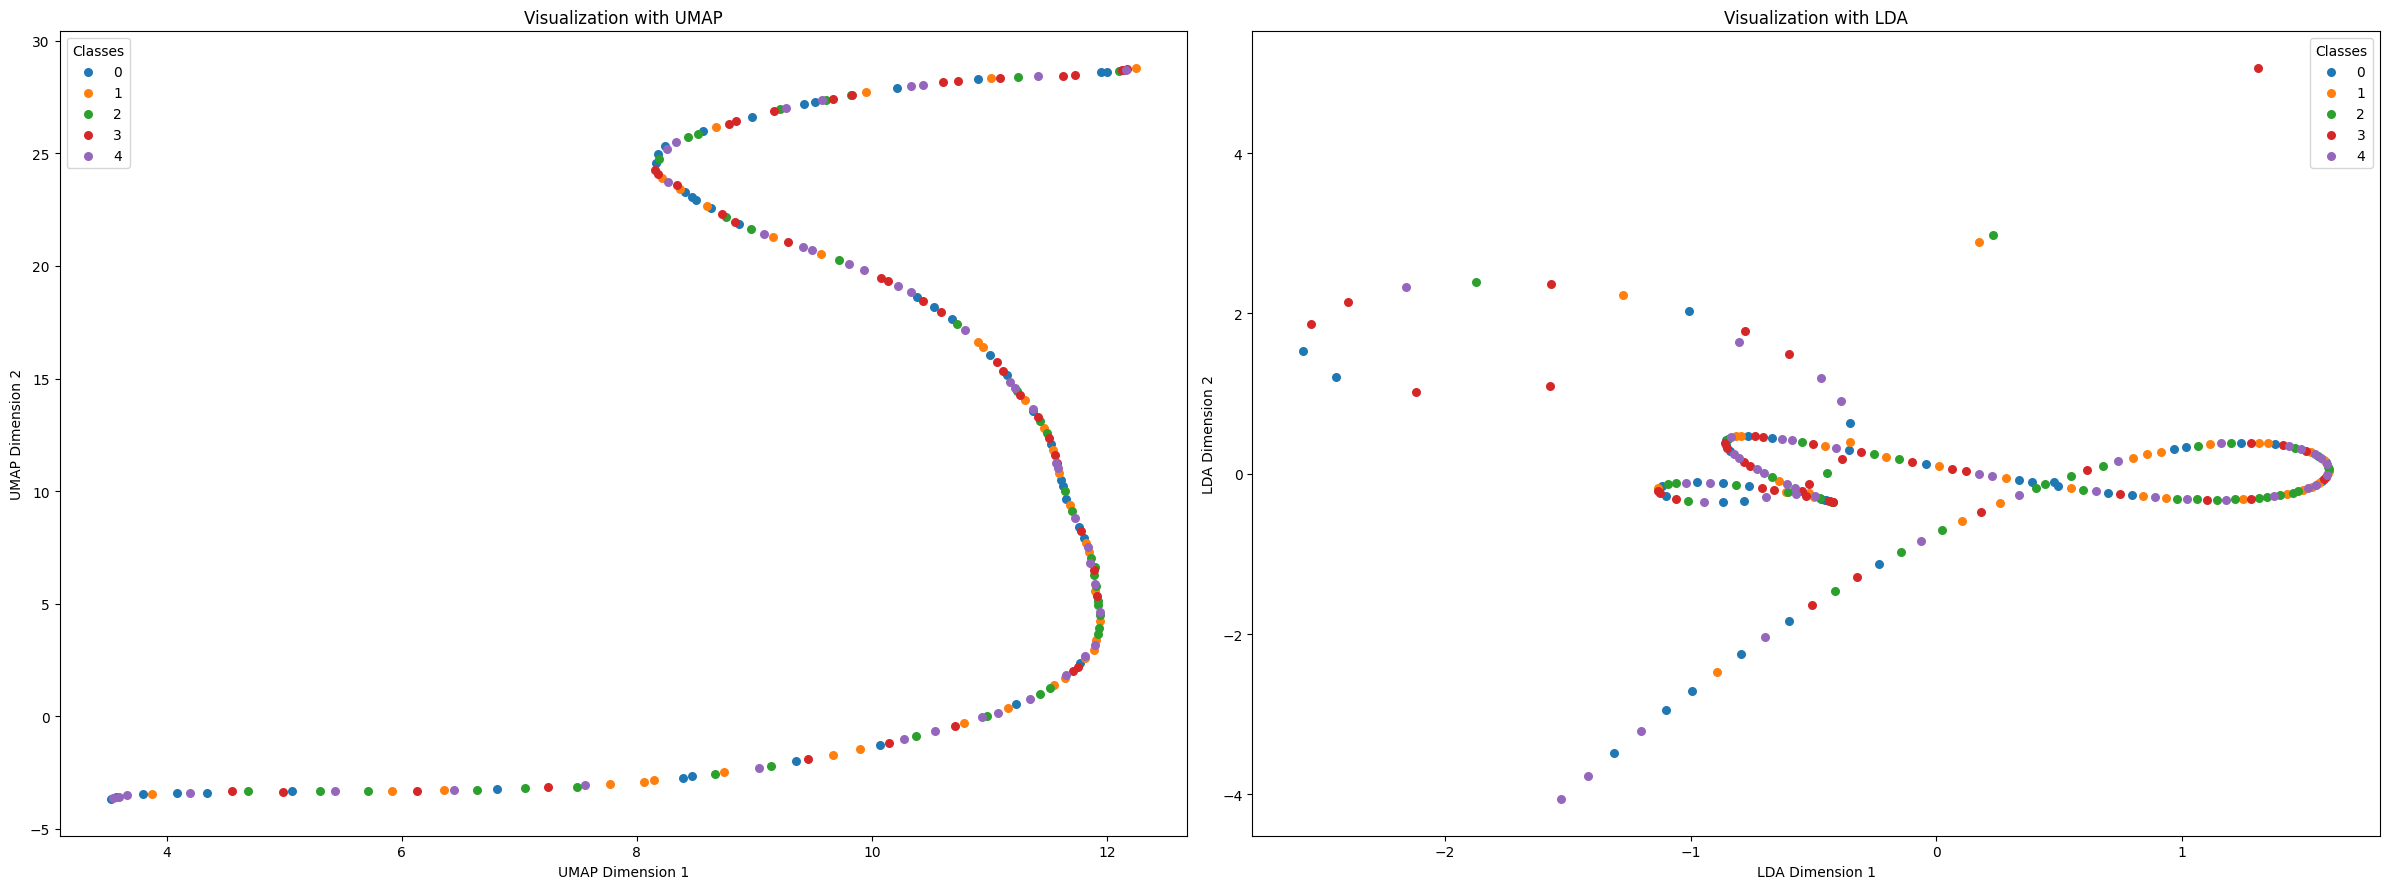

(200, 2)

In [23]:
#| test reduce_dimensions_latent_space
orbit_data = get_example_orbit_data()
orbit_data.shape

# Reshape data to 2D (num_orbits, 6 * num_time_points)
orbit_data_reshaped = orbit_data.reshape(200, -1)

# Use PCA to reduce to a lower-dimensional space (e.g., 10 dimensions)
pca = PCA(n_components=10)
latent_representations = pca.fit_transform(orbit_data_reshaped)

labels = np.random.randint(0, 5, size=200)  # 5 different classes

reduced_latent_spaces = reduce_dimensions_latent_space(latent_representations, labels, techniques=['UMAP','LDA'])
reduced_latent_spaces['UMAP'].shape

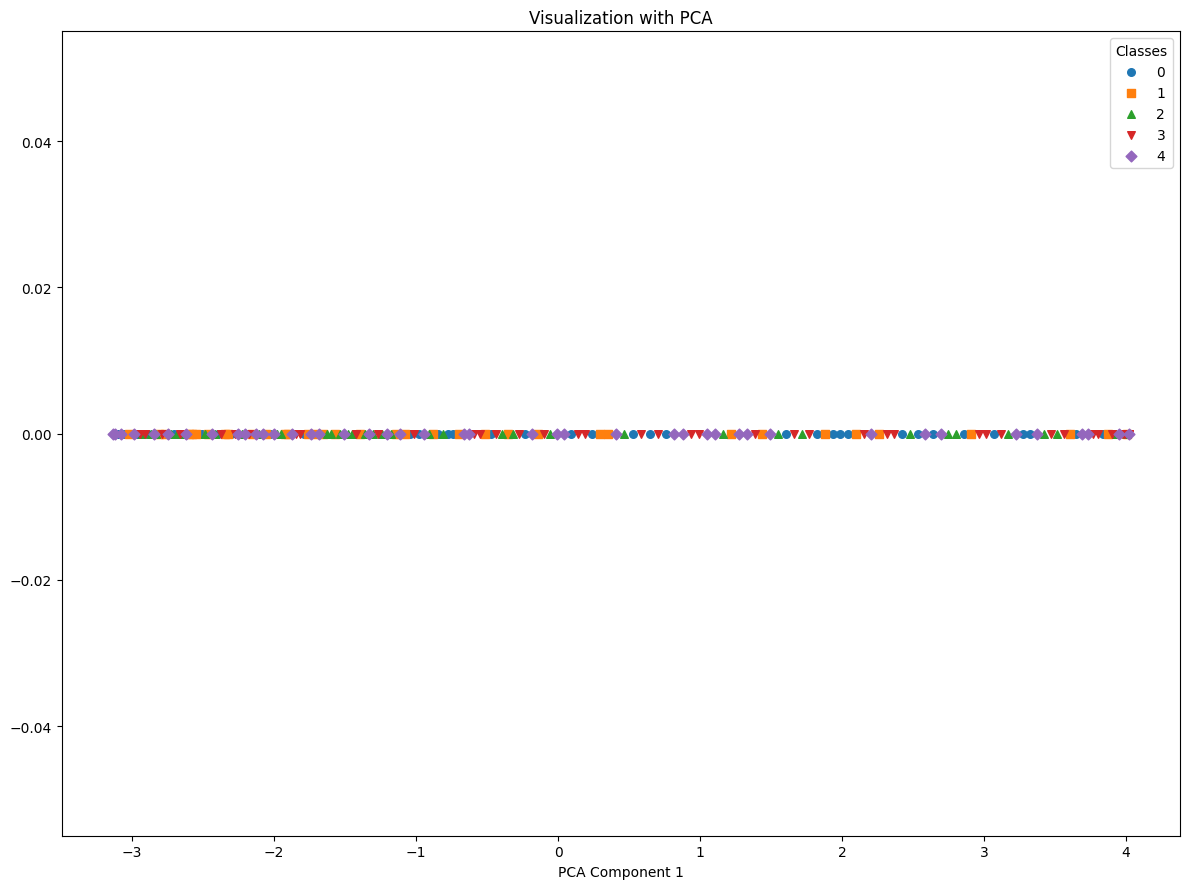

(200, 1)

In [24]:
#| test reduce_dimensions_latent_space
reduced_latent_spaces=reduce_dimensions_latent_space(latent_representations, labels, techniques=['PCA'], n_components=1, many_classes=True)
reduced_latent_spaces['PCA'].shape

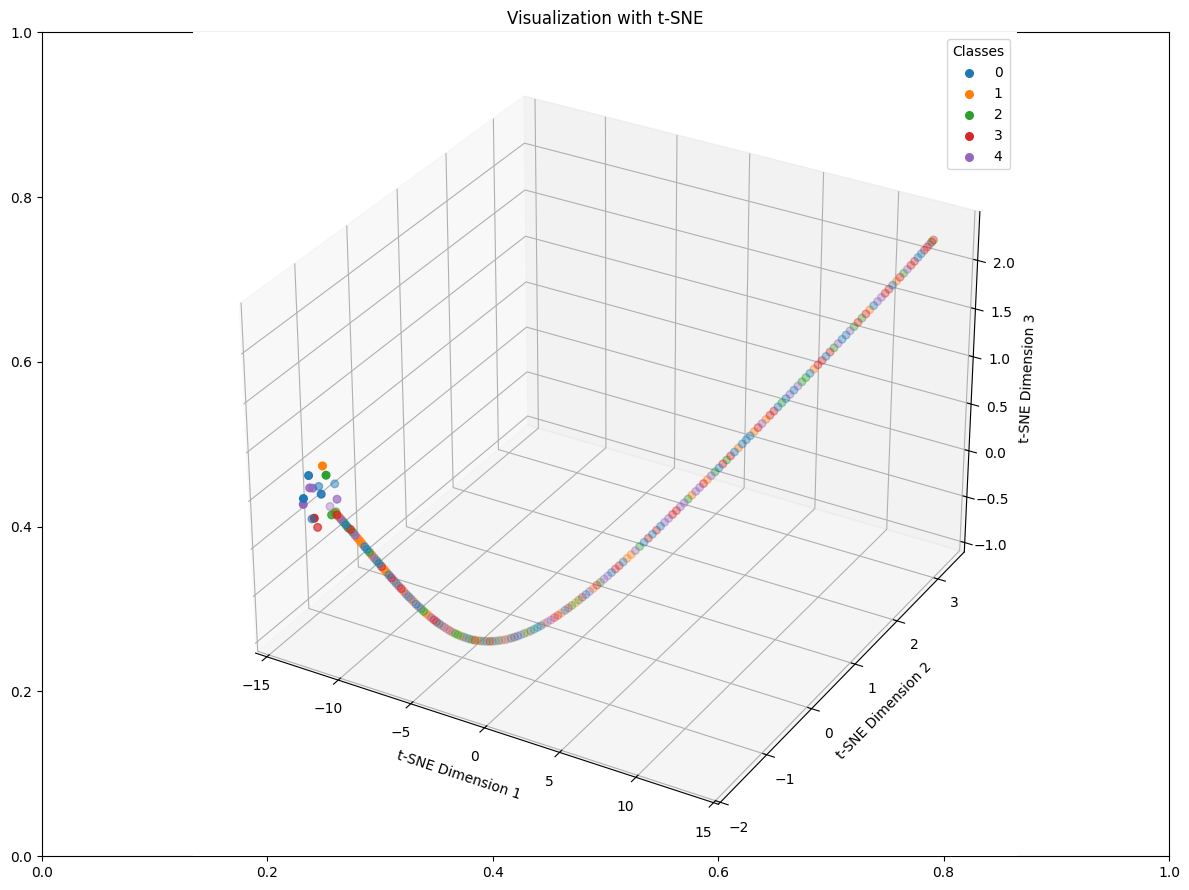

(200, 3)

In [25]:
#| test reduce_dimensions_latent_space
reduced_latent_spaces=reduce_dimensions_latent_space(latent_representations, labels, techniques=['t-SNE'], n_components=3)
reduced_latent_spaces['t-SNE'].shape

## Exploring

In [26]:
#| export
def linear_interpolation(z1, z2, steps):
    """Perform linear interpolation between two points."""
    return np.linspace(z1, z2, steps)

def slerp(z1, z2, steps):
    """Perform spherical linear interpolation between two points."""
    z1_norm = z1 / np.linalg.norm(z1)
    z2_norm = z2 / np.linalg.norm(z2)
    dot_product = np.clip(np.dot(z1_norm, z2_norm), -1.0, 1.0)
    omega = np.arccos(dot_product)
    if omega == 0:
        return np.tile(z1, (steps, 1))
    sin_omega = np.sin(omega)
    return np.array([
        (np.sin((1 - t) * omega) / sin_omega) * z1 +
        (np.sin(t * omega) / sin_omega) * z2
        for t in np.linspace(0, 1, steps)
    ])

def interpolate_sample(centroids, granularity=10, variance=0.0):
    """
    Perform interpolating sampling between all pairs of centroids.

    Parameters:
    - centroids (np.ndarray): Array of shape (n_centroids, latent_dim).
    - granularity (int): Number of interpolation steps between each pair.
    - variance (float): Standard deviation for Gaussian sampling.

    Returns:
    - samples (np.ndarray): Array of sampled points.
    """
    latent_dim = centroids.shape[1]
    samples = []

    for z1, z2 in combinations(centroids, 2):
        if latent_dim <= 2:
            interpolated = linear_interpolation(z1, z2, granularity)
        else:
            interpolated = slerp(z1, z2, granularity)
        
        if variance > 0:
            noise = np.random.normal(0, variance, interpolated.shape)
            interpolated += noise
        
        samples.append(interpolated)
    
    if samples:
        return np.vstack(samples)
    else:
        return np.empty((0, latent_dim))

In [27]:
# Define example centroids for a 2-dimensional latent space
centroids = np.array([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0]
])

granularity = 3
variance = 0.0  # Set to 0 for deterministic interpolation

sampled_points = interpolate_sample(centroids, granularity, variance)

# Define the expected sampled points manually for granularity=3
expected_data = np.array([
    [1.0, 2.0],
    [2.0, 3.0],
    [3.0, 4.0],
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0],
    [3.0, 4.0],
    [4.0, 5.0],
    [5.0, 6.0]
])

# Check the sampled points against the expected data
test_eq(sampled_points, expected_data)

In [28]:
#| export
def compute_centroids(latents, labels, method='mean', return_labels=False, **kwargs):
    """
    Compute the centroid of each class in the latent space using various methods.
    
    Parameters:
    - latents (np.ndarray): Array of shape (n_samples, latent_dim).
    - labels (np.ndarray): Array of shape (n_samples,) with class labels.
    - method (str): Method to compute centroids. Options: 'mean', 'median', 'geom_median', 'medoid', 'trimmed_mean', 'gmm'.
    - return_labels (bool): If True, also return the unique labels corresponding to the centroids.
    - kwargs: Additional arguments for specific methods.
    
    Returns:
    - centroids (np.ndarray): Array of shape (n_classes, latent_dim) containing centroids.
    - unique_labels (np.ndarray, optional): Array of shape (n_classes,) with unique class labels.
    """
    unique_labels = np.unique(labels)
    centroids = []
    
    for label in unique_labels:
        class_points = latents[labels == label]
        
        if method == 'mean':
            centroid = class_points.mean(axis=0)
        
        elif method == 'median':
            centroid = np.median(class_points, axis=0)
        
        elif method == 'geom_median':
            centroid = geometric_median(class_points, tol=kwargs.get('tol', 1e-5))
        
        elif method == 'medoid':
            centroid = compute_medoid(class_points)
        
        elif method == 'trimmed_mean':
            trim_ratio = kwargs.get('trim_ratio', 0.1)
            centroid = trimmed_mean_centroid(class_points, trim_ratio=trim_ratio)
        
        elif method == 'gmm':
            n_components = kwargs.get('n_components', 1)
            if n_components != 1:
                raise ValueError("GMM-based centroids require n_components=1 for simple centroid computation.")
            gmm = GaussianMixture(n_components=1)
            gmm.fit(class_points)
            centroid = gmm.means_[0]
        
        else:
            raise ValueError(f"Unsupported centroid computation method: {method}")
        
        centroids.append(centroid)
    
    centroids = np.array(centroids)
    
    if return_labels:
        return centroids, unique_labels
    else:
        return centroids

# Auxiliary Functions
def geometric_median(points, tol=1e-5):
    y = np.mean(points, axis=0)
    while True:
        D = distance.cdist([y], points, 'euclidean')[0]
        nonzeros = (D != 0)
        
        if not np.any(nonzeros):
            return y
        
        D = D[nonzeros]
        points_nonzero = points[nonzeros]
        y1 = np.sum(points_nonzero / D[:, np.newaxis], axis=0) / np.sum(1 / D)
        
        if np.linalg.norm(y - y1) < tol:
            return y1
        y = y1

def compute_medoid(points):
    dist_matrix = distance.cdist(points, points, 'euclidean')
    medoid_index = np.argmin(dist_matrix.sum(axis=1))
    return points[medoid_index]

def trimmed_mean_centroid(points, trim_ratio=0.1):
    trimmed_points = []
    for dim in range(points.shape[1]):
        sorted_dim = np.sort(points[:, dim])
        trim = int(trim_ratio * len(sorted_dim))
        trimmed_dim = sorted_dim[trim: -trim]
        trimmed_points.append(trimmed_dim)
    return np.array([np.mean(dim) for dim in trimmed_points])

In [29]:
#| hide

# Define example latent representations
latents = np.array([
    [1.0, 2.0],
    [1.5, -1.0],
    [2.0, -1.0],
    [1.2, 2.2],
    [1.4, 1.8],
    [1.7, 7.0]
])

# Define corresponding labels
labels = np.array([1,1,1,2,2,3])

# Compute centroids without returning labels
centroids = compute_centroids(latents, labels)

# Define the expected centroids
expected_centroids = np.array([
    [1.5, 0.],        # Centroid for label 1
    [1.3, 2.],        # Centroid for label 2
    [1.7, 7.]         # Centroid for label 2
])

# Check the computed centroids against the expected data
test_close(centroids, expected_centroids)

In [30]:
#| hide
import nbdev; nbdev.nbdev_export()